In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import sys
import os
import torch
import torch.nn.functional as F


In [2]:
# class_names = train_dataset.classes  # ['anomaly', 'normal']

# data_iter = iter(train_loader)
# images, labels = next(data_iter)

# plt.figure(figsize=(5, 5))
# for i in range(16):
#     plt.subplot(4, 4, i + 1)
#     img = images[i].permute(1, 2, 0)
#     label = class_names[labels[i]]
#     plt.imshow(img)
#     plt.title(label)
#     plt.axis('off')

# plt.tight_layout()
# plt.show()

# Method 1, flatten the input as a long array. 

In [3]:
# # 1) Check folder contents
# import os

# print("Train split:")
# for cls in ("normal","anomaly"):
#     p = f"../split_anomaly_dataset/train/{cls}"
#     cnt = len([f for f in os.listdir(p) if f.lower().endswith(('.jpg','.png'))]) \
#           if os.path.isdir(p) else 0
#     print(f"  {cls:7s}: {cnt} files")

# # 2) Load with allow_empty
# from torchvision import datasets, transforms

# tf = transforms.Compose([transforms.Resize((64,64)), transforms.ToTensor()])
# train_ds = datasets.ImageFolder("../split_anomaly_dataset/train", transform=tf, allow_empty=True)
# print("Classes loaded:", train_ds.classes)
# print("Number of samples:", len(train_ds))


In [4]:
# # %% [markdown]
# # # DAGMM Anomaly Detection with Sampled Anomalies in Train

# # %% [code]
# # 1) Make your DAGMM code importable
# import sys, os
# from pathlib import Path
# sys.path.insert(0, str(Path.cwd().parent / "Appropriate_dagmm"))

# # %% [code]
# # 2) Imports
# import torch
# import torch.nn.functional as F
# from torch.utils.data import DataLoader
# from torchvision import transforms, datasets
# from collections import Counter

# from model import DAGMM  # your revised model.py

# # %% [code]
# # 3) Data transforms & loaders (images → flattened vectors)
# transform = transforms.Compose([
#     transforms.Resize((64,64)),
#     transforms.ToTensor(),
# ])

# train_ds = datasets.ImageFolder("../split_anomaly_dataset/train", transform=transform, allow_empty=True)
# test_ds  = datasets.ImageFolder("../split_anomaly_dataset/test",  transform=transform)

# train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  drop_last=True)
# test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, drop_last=False)

# # Print ground‑truth counts
# print("Train class counts:", {train_ds.classes[k]: v for k,v in Counter(train_ds.targets).items()})
# print("Test  class counts:", {test_ds.classes[k]: v for k,v in Counter(test_ds.targets).items()})

# # %% [code]
# # 4) Model + optimizer
# device = torch.device("mps" if torch.cuda.is_available() else "cpu")
# n_features = 3 * 64 * 64

# model = DAGMM(
#     input_dim        = n_features,
#     latent_dim       = 10,
#     n_gmm_components = 5,
#     comp_kwargs      = {'hidden_dims':[128,64], 'activation':torch.nn.Tanh},
#     est_kwargs       = {'hidden_dims':[32],      'activation':torch.nn.ReLU, 'dropout':0.3},
#     device           = device
# ).to(device)

# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# # %% [code]
# # 5) Training loop
# n_epochs = 30
# for epoch in range(1, n_epochs+1):
#     model.train()
#     running_loss = 0.0
#     for imgs, _ in train_loader:
#         x = imgs.view(imgs.size(0), -1).to(device)  # flatten
#         out  = model(x)
#         loss = model.loss_function(x, out)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item() * x.size(0)
#     avg_loss = running_loss / len(train_loader.dataset)
#     print(f"Epoch {epoch}/{n_epochs} — avg train loss: {avg_loss:.4f}")

# # %% [code]
# # 6) Scoring test set & thresholding
# model.eval()
# energies = []
# with torch.no_grad():
#     for imgs, _ in test_loader:
#         x = imgs.view(imgs.size(0), -1).to(device)
#         energies.append(model(x)['energy'].cpu())
# energies = torch.cat(energies)

# # 95th‐percentile threshold
# thr = energies.quantile(0.80)
# mask = energies > thr
# print(f"Detected anomalies in test set: {mask.sum().item()} / {len(energies)}")

# # %% [code]
# # 7) (Optional) Visualize
# import matplotlib.pyplot as plt
# plt.hist(energies.numpy(), bins=50, alpha=0.7)
# plt.axvline(thr, color='r', linestyle='--', label='95% threshold')
# plt.legend(); plt.title("Test Energy Distribution"); plt.show()


In [5]:
# import torch
# from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# # 1) Recompute energies **and** collect true labels in the same order
# model.eval()
# energies = []
# y_true   = []
# with torch.no_grad():
#     for imgs, labels in test_loader:
#         x = imgs.view(imgs.size(0), -1).to(device)
#         energies.append(model(x)['energy'].cpu())
#         y_true.append(labels)
# energies = torch.cat(energies)         # shape [N_test]
# y_true   = torch.cat(y_true)           # shape [N_test]

# # 2) Choose a threshold (you could sweep this on a val set)
# thr = energies.quantile(0.95)

# # 3) Build binary predictions: 1=anomaly, 0=normal
# y_pred = (energies > thr).int()

# # 4) Confusion matrix & classification report
# print("Confusion matrix:")
# print(confusion_matrix(y_true, y_pred))
# print("Accuracy")
# print(f"Accuracy: {100 * (y_true == y_pred).float().mean():.2f}%")
# print("\nClassification report:")
# print(classification_report(y_true, y_pred, target_names=test_ds.classes))

# # 5) (Optional) AUC of the energy scores
# auc = roc_auc_score(y_true, -energies)  # we invert since lower energy = more normal
# print(f"\nROC‑AUC (energy as score): {auc:.3f}")


In [6]:
# # get top‑k highest‑energy samples
# k = 5
# idx = torch.topk(energies, k=k).indices

# # grab their file paths & labels
# for i in idx:
#     path, label = test_ds.samples[i]
#     print(f"{path}  →  label={test_ds.classes[label]}, energy={energies[i]:.3f}")


# Method 2, use cnn based architecture 

In [7]:
# 0) Point to your CNN‑DAGMM folder *before* any imports
import sys, importlib
from pathlib import Path

cnn_dir = Path.cwd().parent / "cnn_dagmm"
sys.path.insert(0, str(cnn_dir))

# 1) Import & force‑reload to clear any old cache
import compression_network, model
importlib.reload(compression_network)
importlib.reload(model)

# 2) Verify you’re using the right files
print("CompressionNetwork from:", compression_network.__file__)
print("DAGMM   from:",           model.__file__)


CompressionNetwork from: /Users/aryan/Desktop/Academics /Semester 4/Data science/Project/gmm_anomalydetection/cnn_dagmm/compression_network.py
DAGMM   from: /Users/aryan/Desktop/Academics /Semester 4/Data science/Project/gmm_anomalydetection/cnn_dagmm/model.py


Train class counts: {'normal': 284}
Test  class counts: {'anomaly': 20, 'normal': 95}
Epoch 1/30 — avg train loss: 36.6269
Epoch 2/30 — avg train loss: 21.1110
Epoch 3/30 — avg train loss: 16.0705
Epoch 4/30 — avg train loss: 14.5800
Epoch 5/30 — avg train loss: 13.6081
Epoch 6/30 — avg train loss: 13.1374
Epoch 7/30 — avg train loss: 12.6400
Epoch 8/30 — avg train loss: 12.4542
Epoch 9/30 — avg train loss: 12.0915
Epoch 10/30 — avg train loss: 11.4879
Epoch 11/30 — avg train loss: 11.2674
Epoch 12/30 — avg train loss: 10.8162
Epoch 13/30 — avg train loss: 10.4227
Epoch 14/30 — avg train loss: 10.2395
Epoch 15/30 — avg train loss: 9.8681
Epoch 16/30 — avg train loss: 9.4231
Epoch 17/30 — avg train loss: 9.1512
Epoch 18/30 — avg train loss: 9.0032
Epoch 19/30 — avg train loss: 8.9751
Epoch 20/30 — avg train loss: 8.6697
Epoch 21/30 — avg train loss: 8.3703
Epoch 22/30 — avg train loss: 8.2131
Epoch 23/30 — avg train loss: 8.0712
Epoch 24/30 — avg train loss: 7.8517
Epoch 25/30 — avg tra

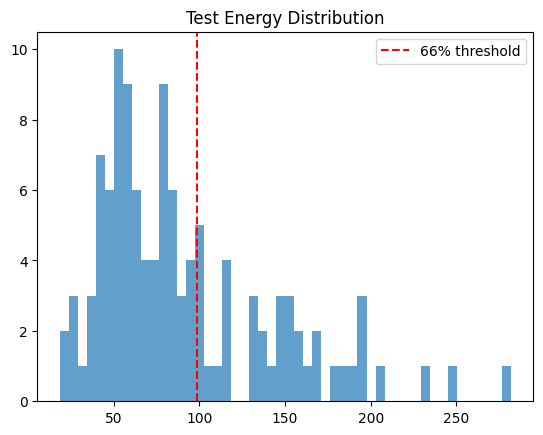

In [8]:
# %% [markdown]
# # DAGMM Anomaly Detection with Sampled Anomalies in Train

# %% [code]
# 1) Make your DAGMM code importable
import sys, os
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent / "cnn_dagmm"))

# %% [code]
# 2) Imports
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from collections import Counter

from model import DAGMM  # your revised model.py

# %% [code]
# 3) Data transforms & loaders (images → flattened vectors)
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
])

train_ds = datasets.ImageFolder("../split_anomaly_dataset/train", transform=transform, allow_empty=True)
test_ds  = datasets.ImageFolder("../split_anomaly_dataset/test",  transform=transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  drop_last=True)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, drop_last=False)

# Print ground‑truth counts
print("Train class counts:", {train_ds.classes[k]: v for k,v in Counter(train_ds.targets).items()})
print("Test  class counts:", {test_ds.classes[k]: v for k,v in Counter(test_ds.targets).items()})

# %% [code]
# 4) Model + optimizer
device = torch.device("mps" if torch.cuda.is_available() else "cpu")
n_features = 3 * 64 * 64

model = DAGMM(
    input_dim        = 3 * 64 * 64,     # still required by signature but not forwarded to CompressionNetwork
    latent_dim       = 2,
    n_gmm_components = 2,
    comp_kwargs      = {'latent_dim': 2},  # now cleanly matches CompressionNetwork
    est_kwargs       = {'hidden_dims': [32], 'activation': torch.nn.ReLU, 'dropout': 0.3},
    device           = device
).to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# %% [code]
# 5) Training loop
n_epochs = 30
for epoch in range(1, n_epochs+1):
    model.train()
    running_loss = 0.0
    for imgs, _ in train_loader:
        x = imgs.to(device) 
        out  = model(x)
        loss = model.loss_function(x, out)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)
    avg_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}/{n_epochs} — avg train loss: {avg_loss:.4f}")

# %% [code]
# 6) Scoring test set & thresholding
model.eval()
energies = []
with torch.no_grad():
    for imgs, _ in test_loader:
        x = imgs.to(device)
        energies.append(model(x)['energy'].cpu())
energies = torch.cat(energies)

# 95th‐percentile threshold
thr = energies.quantile(0.70)
mask = energies > thr
print(f"Detected anomalies in test set: {mask.sum().item()} / {len(energies)}")

# %% [code]
# 7) (Optional) Visualize
import matplotlib.pyplot as plt
plt.hist(energies.numpy(), bins=50, alpha=0.7)
plt.axvline(thr, color='r', linestyle='--', label='66% threshold')
plt.legend(); plt.title("Test Energy Distribution"); plt.show()


In [ ]:
import torch
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# 1) Recompute energies and collect true labels
model.eval()
energies = []
y_true   = []
with torch.no_grad():
    for imgs, labels in test_loader:
        x = imgs.to(device)                       # CNN takes [B,3,64,64]
        out = model(x)
        energies.append(out['energy'].cpu())      # [B]
        y_true.append(labels)
energies = torch.cat(energies)                  # [N_test]
y_true   = torch.cat(y_true)                    # [N_test]

# 2) Identify top 30% highest‐energy samples as anomalies
#    70th percentile cutoff → top 30% above this
thr = energies.quantile(0.66)


# 3) Predictions
y_pred = (energies > thr).int()

# 4) Metrics
print("Threshold for top 30% anomalies:", thr.item())
print("\nConfusion matrix:")
print(confusion_matrix(y_true, y_pred))

acc = (y_true == y_pred).float().mean() * 100
print(f"\nAccuracy: {acc:.2f}%\n")

print("Classification report:")
print(classification_report(y_true, y_pred, target_names=test_ds.classes))

# 5) ROC‑AUC (still informative even though we fix the cutoff by proportion)
auc = roc_auc_score(y_true, -energies)  # invert since lower energy = more normal
print(f"\nROC‑AUC (energy as score): {auc:.3f}")


Threshold for top 30% anomalies: 193.5363006591797

Confusion matrix:
[[15  5]
 [94  1]]

Accuracy: 13.91%

Classification report:
              precision    recall  f1-score   support

     anomaly       0.14      0.75      0.23        20
      normal       0.17      0.01      0.02        95

    accuracy                           0.14       115
   macro avg       0.15      0.38      0.13       115
weighted avg       0.16      0.14      0.06       115


ROC‑AUC (energy as score): 0.831


In [ ]:
# # %% [code]
# # Hyperparameter grid search for DAGMM
# import itertools
# import pandas as pd
# import torch
# from torch.utils.data import DataLoader
# from torchvision import transforms, datasets
# from model import DAGMM

# # 1) Data loaders (reuse from above)
# transform = transforms.Compose([
#     transforms.Resize((64,64)),
#     transforms.ToTensor(),
# ])
# train_ds = datasets.ImageFolder("../split_anomaly_dataset/train", transform=transform, allow_empty=True)
# test_ds  = datasets.ImageFolder("../split_anomaly_dataset/test",  transform=transform)
# train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  drop_last=True)
# test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, drop_last=False)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # 2) Define search space
# param_grid = {
#     "latent_dim":       [2, 5, 10],
#     "n_gmm_components": [2, 4, 6],
#     "est_hidden":       [[32], [64, 32]],
#     "dropout":          [0.1, 0.3],
#     "lr":               [1e-3, 1e-4],
# }

# # 3) Helper to train & evaluate one config
# def run_experiment(cfg):
#     # build model
#     model = DAGMM(
#         input_dim        = 3*64*64,
#         latent_dim       = cfg["latent_dim"],
#         n_gmm_components = cfg["n_gmm_components"],
#         comp_kwargs      = {"latent_dim": cfg["latent_dim"]},
#         est_kwargs       = {
#             "input_dim": cfg["latent_dim"]+2,
#             "output_dim": cfg["n_gmm_components"],
#             "hidden_dims": cfg["est_hidden"],
#             "activation": torch.nn.ReLU,
#             "dropout": cfg["dropout"]
#         },
#         device=device
#     ).to(device)
#     opt = torch.optim.Adam(model.parameters(), lr=cfg["lr"])

#     # train for fixed epochs
#     for epoch in range(1, 11):
#         model.train()
#         for imgs, _ in train_loader:
#             x = imgs.to(device)
#             out = model(x)
#             loss = model.loss_function(x, out)
#             opt.zero_grad(); loss.backward(); opt.step()

#     # evaluate: compute energy scores & threshold at 90th percentile
#     model.eval()
#     energies, y_true = [], []
#     with torch.no_grad():
#         for imgs, labels in test_loader:
#             x = imgs.to(device)
#             energies.append(model(x)["energy"].cpu())
#             y_true.append(labels)
#     energies = torch.cat(energies)
#     y_true   = torch.cat(y_true)

#     thr = energies.quantile(0.9)
#     y_pred = (energies > thr).int()
#     acc = (y_pred == y_true).float().mean().item()

#     return acc

# # 4) Run grid search
# results = []
# for vals in itertools.product(*param_grid.values()):
#     cfg = dict(zip(param_grid.keys(), vals))
#     acc = run_experiment(cfg)
#     print(f"Config {cfg} → accuracy {acc:.3f}")
#     results.append({**cfg, "accuracy": acc})

# # 5) Summarize
# df = pd.DataFrame(results)
# print("\nTop 5 configs by accuracy:")
# print(df.sort_values("accuracy", ascending=False).head())


KeyboardInterrupt: 

In [11]:
# df.sort_values("accuracy", ascending=False).head()

In [18]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from model import DAGMM

# 1) Synthesize 100 images
white_imgs   = torch.ones(80, 3, 64, 64)
colored_imgs = torch.zeros(20, 3, 64, 64); colored_imgs[:,0] = 1.0
labels       = torch.cat([torch.zeros(80), torch.ones(20)]).long()

# single dataset
dataset = TensorDataset(torch.cat([white_imgs, colored_imgs], 0), labels)

# train loader (shuffle)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

# eval loader (no shuffle)
eval_loader  = DataLoader(dataset, batch_size=16, shuffle=False)

# 2) Build & train DAGMM
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DAGMM(
    input_dim=3*64*64, latent_dim=2, n_gmm_components=2,
    comp_kwargs={'latent_dim':2},
    est_kwargs ={
        'input_dim': 2+2,
        'output_dim': 2,
        'hidden_dims':[4],
        'activation':torch.nn.ReLU,
        'dropout':0.1
    },
    device=device
).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# 3) Train on white only
for epoch in range(1, 51):
    model.train()
    total_loss = 0.0
    n_whites = 0
    for x_batch, y_batch in train_loader:
        mask = (y_batch == 0)
        if not mask.any():
            continue
        x = x_batch[mask].to(device)
        out = model(x)
        loss = model.loss_function(x, out)
        opt.zero_grad()
        loss.backward()
        opt.step()

        total_loss += loss.item() * x.size(0)
        n_whites   += x.size(0)

    if epoch % 10 == 0 and n_whites > 0:
        print(f"Epoch {epoch:02d} — avg white-loss: {total_loss / n_whites:.4f}")

# 4) Compute energies & collect labels
model.eval()
energies = []
labels_list = []
with torch.no_grad():
    for x_batch, y_batch in eval_loader:
        x = x_batch.to(device)
        out = model(x)
        energies.append(out['energy'].cpu())
        labels_list.append(y_batch)

energies = torch.cat(energies)     # [100]
labels   = torch.cat(labels_list)  # [100]

# 5) Inspect distributions by label
white_e = energies[labels == 0]
red_e   = energies[labels == 1]

print("White  μ±σ:", white_e.mean().item(), white_e.std().item())
print("Red    μ±σ:",   red_e.mean().item(),   red_e.std().item())

plt.hist(white_e, bins=20, alpha=0.6, label='white')
plt.hist(red_e,   bins=20, alpha=0.6, label='red')
plt.legend(); plt.show()

# 6) Mid-point threshold
thr = (white_e.mean() + red_e.mean()) / 2
pred = (energies > thr).int()

print("Detected anomalies:", pred[labels==1].sum().item(), "/ 20")
print("False positives:   ", pred[labels==0].sum().item(), "/ 80")


Epoch 10 — avg white-loss: 5.9115
Epoch 20 — avg white-loss: 2.1444
Epoch 30 — avg white-loss: 1.4583
Epoch 40 — avg white-loss: 1.0694


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 4])

In [19]:
import numpy as np
from sklearn.metrics import roc_curve, f1_score, precision_recall_fscore_support

# assume `energies` [100] and `labels` [100] (0=white,1=red)
y_true = labels.numpy()
y_score = energies.numpy()

# 1) ROC curve and optimal threshold at max (TPR–FPR)
fpr, tpr, thresholds = roc_curve(y_true, y_score)
opt_idx = np.argmax(tpr - fpr)
opt_thr = thresholds[opt_idx]
print(f"Optimal threshold from ROC: {opt_thr:.4f} (TPR={tpr[opt_idx]:.2f}, FPR={fpr[opt_idx]:.2f})")

# 2) Build predictions & compute metrics
y_pred = (energies > opt_thr).int().numpy()
tp, fp, fn, tn = (
    ((y_true==1)&(y_pred==1)).sum(),
    ((y_true==0)&(y_pred==1)).sum(),
    ((y_true==1)&(y_pred==0)).sum(),
    ((y_true==0)&(y_pred==0)).sum(),
)
print("Confusion matrix:")
print(f"  [[TP={tp}, FP={fp}]\n   [FN={fn}, TN={tn}]]")

precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)
print(f"\nPrecision (white,red): {precision}")
print(f"Recall    (white,red): {recall}")
print(f" F1‑score (white,red): {f1}")

# 3) (Optional) print overall F1
print(f"\nOverall F1: {f1_score(y_true, y_pred):.2f}")


ValueError: Found input variables with inconsistent numbers of samples: [100, 115]